# Learning subgridscale parametrizations in a atmospheric toy model 

You can find this notebook and all additional recourses in this GitHub repo: https://github.com/maximilian-gelbrecht/EllisSummerSchool

## ELLIS Summer School Project

* Atmospheric dynamics and ocean dynamics exhibit dynamics on many spatial scales: from small scale turbulance to large scale circulation pattern
* We can't just always increase the resolution to resolve those effects explicilty, espacially for climate models that would be costly
* Subgridscale parametrizations therefore parametrize the effect the smaller scales have on the larger scales
* Recent studies showed the potential of ML for these parametrizations (e.g. [Yuval et al 2021](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020gl091363))
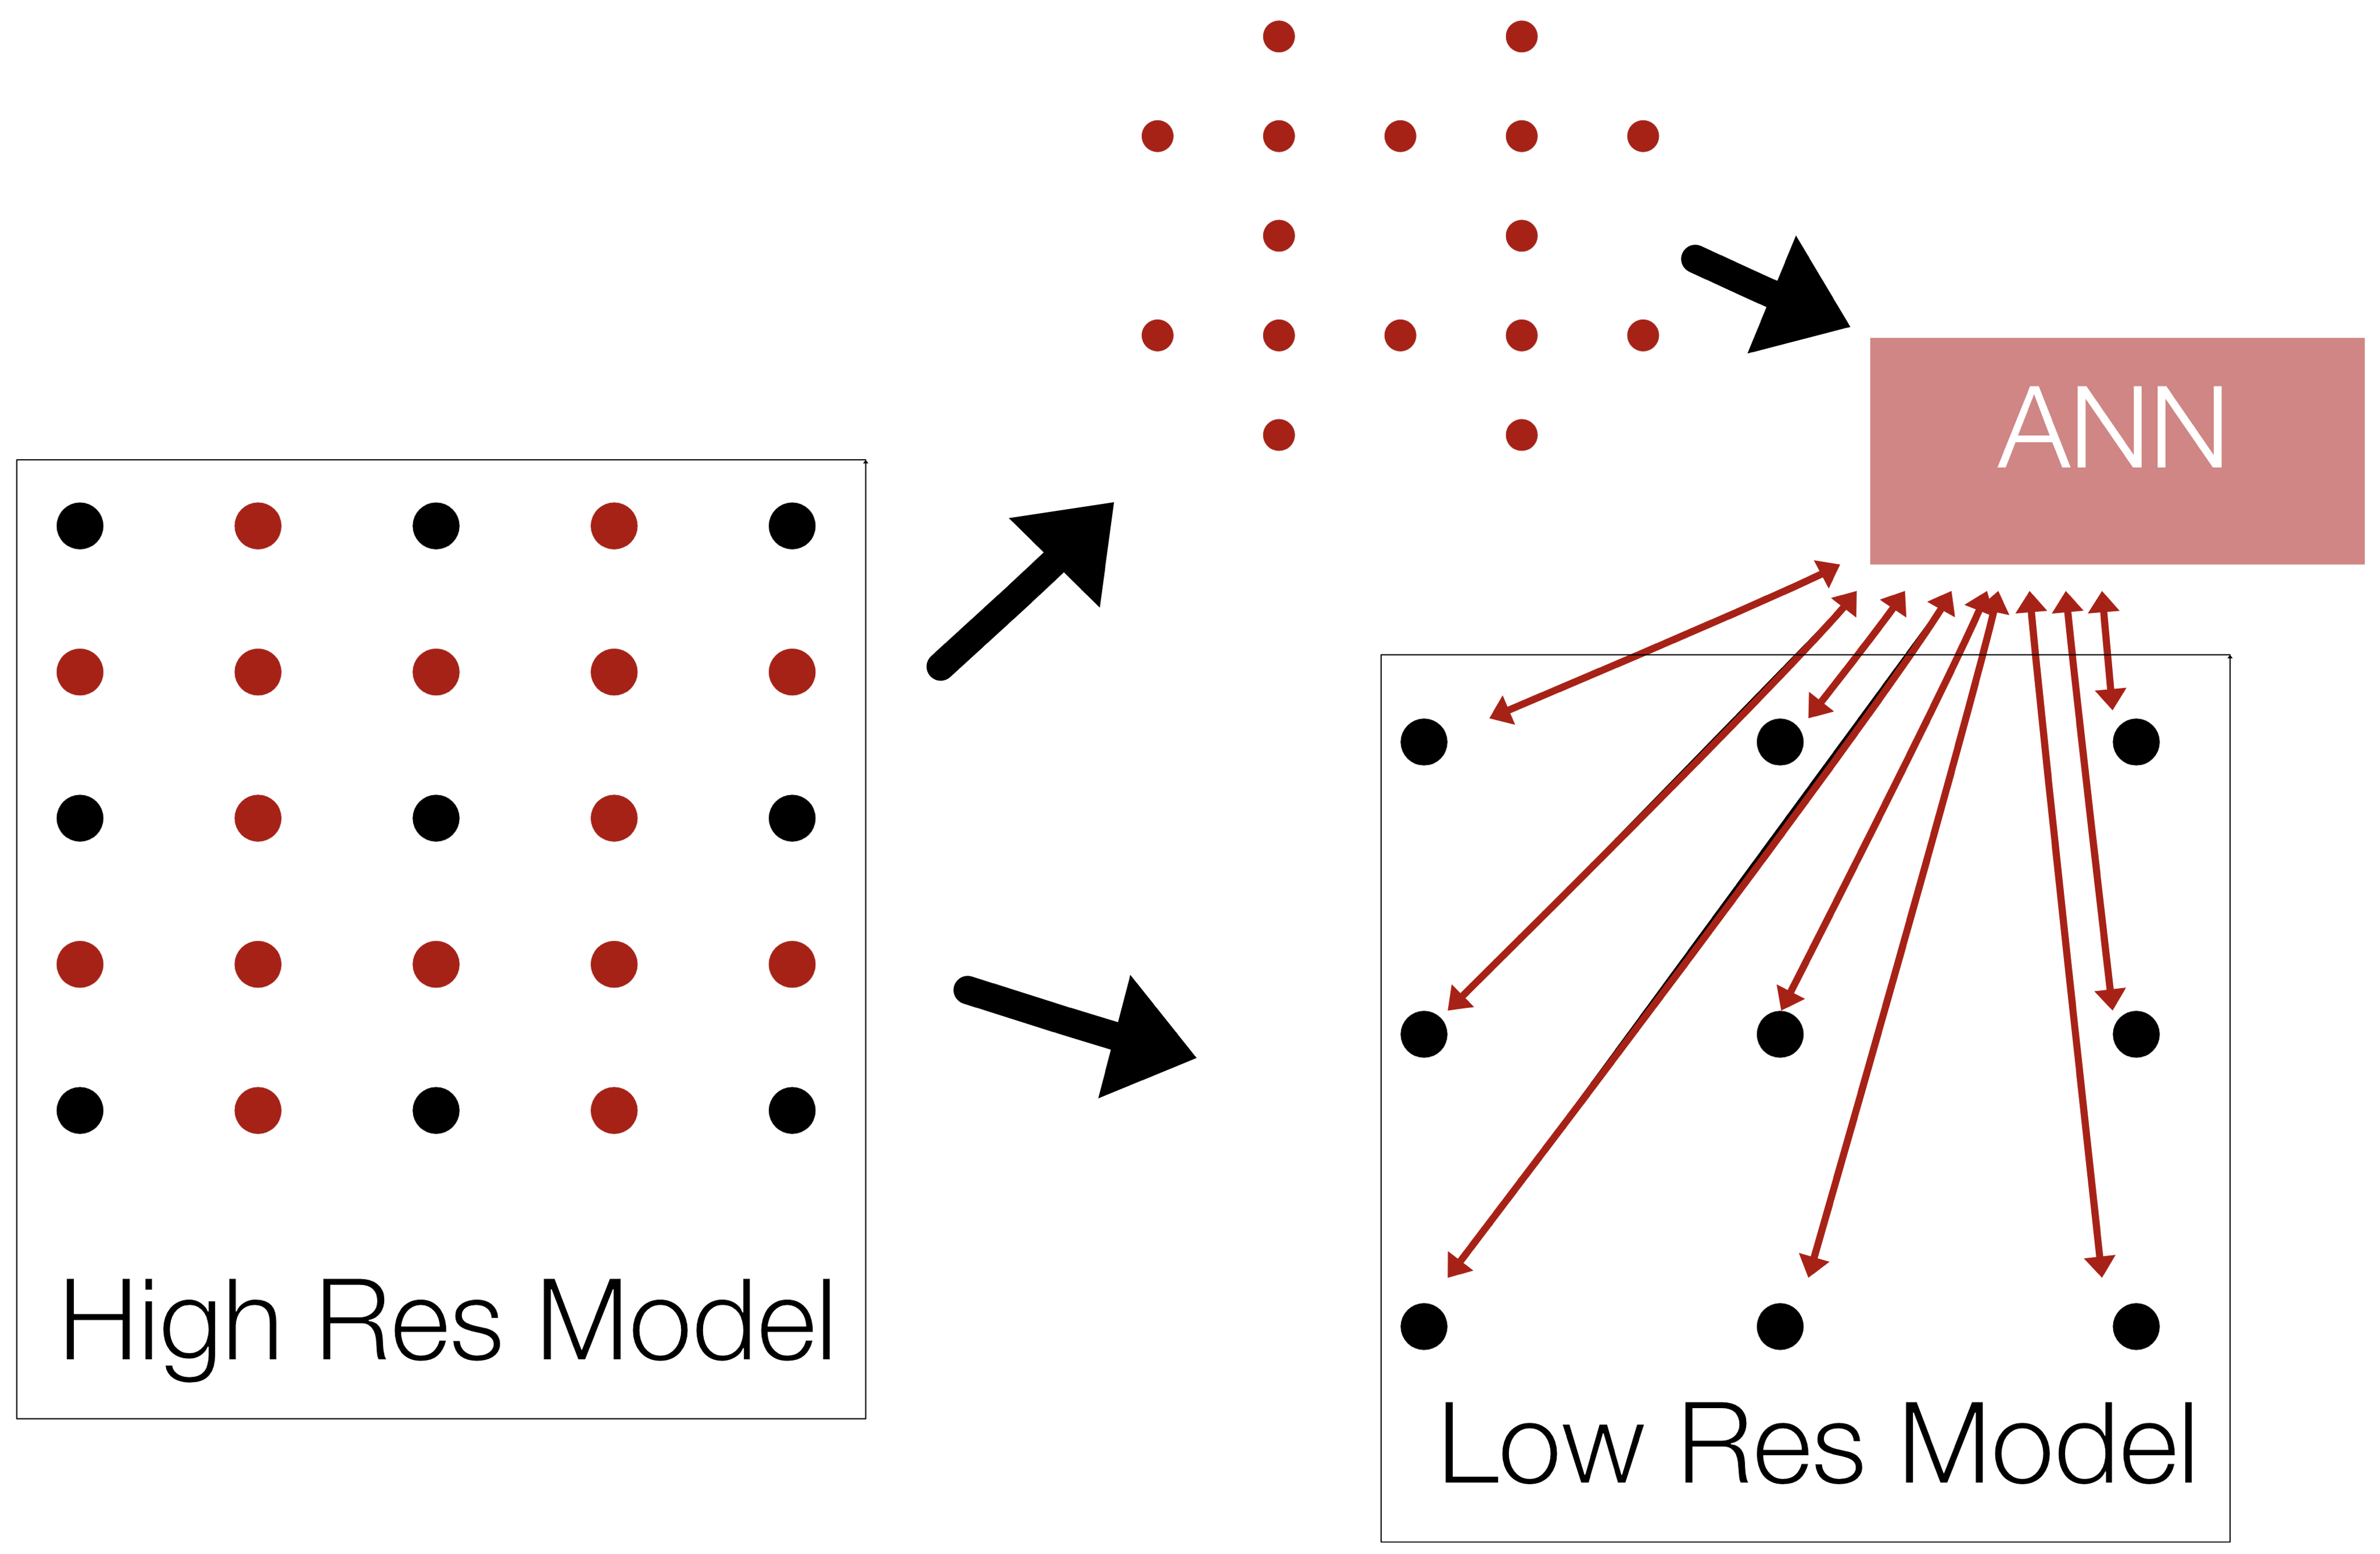


## Lorenz96 System as a conceptual model to test subgridscale parametrizations

* General Circulation Models are computationally very complex and learning 
* Edward Lorenz suggested in 1996 a conceptual model to study the predicitability of the atmosphere, which is also ideally suited for testing subgridscale parametrizations

The two-layer system couples coarse slow ($X$) and small scale fast ($Y$) variables:

$$
\begin{align}
\frac{dX_i}{dt} &= (X_{i+1} - X_{i-2}) X_{i-1} - X_i + F - \frac{hc}{b} \sum_{j=1}^J Y_{i,j} \\
\frac{dY_{i,j}}{dt} &= cb \cdot (Y_{i,j+1} - Y_{i,j-2}) Y_{i,j-1} - c Y_{i,j} + \frac{hc}{b} X_i
\end{align}
$$

where:
- $X_i$ are the slow variables ($i = 1, \ldots, K$), modelling an atmospheric along a latitude ring
- $Y_{i,j}$ are the fast variables ($i = 1, \ldots, K$; $j = 1, \ldots, J$) along the same latitude ring 
- $h$, $c$, $b$ are scale seperation and coupling parameters
- $F$ is the forcing parameter, injecting external energy (from other parts of the atmosphere) 
- $(X_{i+1} - X_{i-2}) X_{i-1}$ can be interpreted as a nonlinear advection
- $-X_i$ as dissipation

### Parameters
- $K$: Number of slow variables (grid points)
- $J$: Number of fast variables per slow variable
- Total variables: $N = K + K \cdot J$

### Boundary Conditions

**Slow variables**: Periodic in $i$: $X_i = X_i + K$

**Fast variables**: Periodic in both $i$ and $j$: $Y_{i,j} = Y_{i+K,j}$; $Y_{i,j} = Y_{i,j+J}$

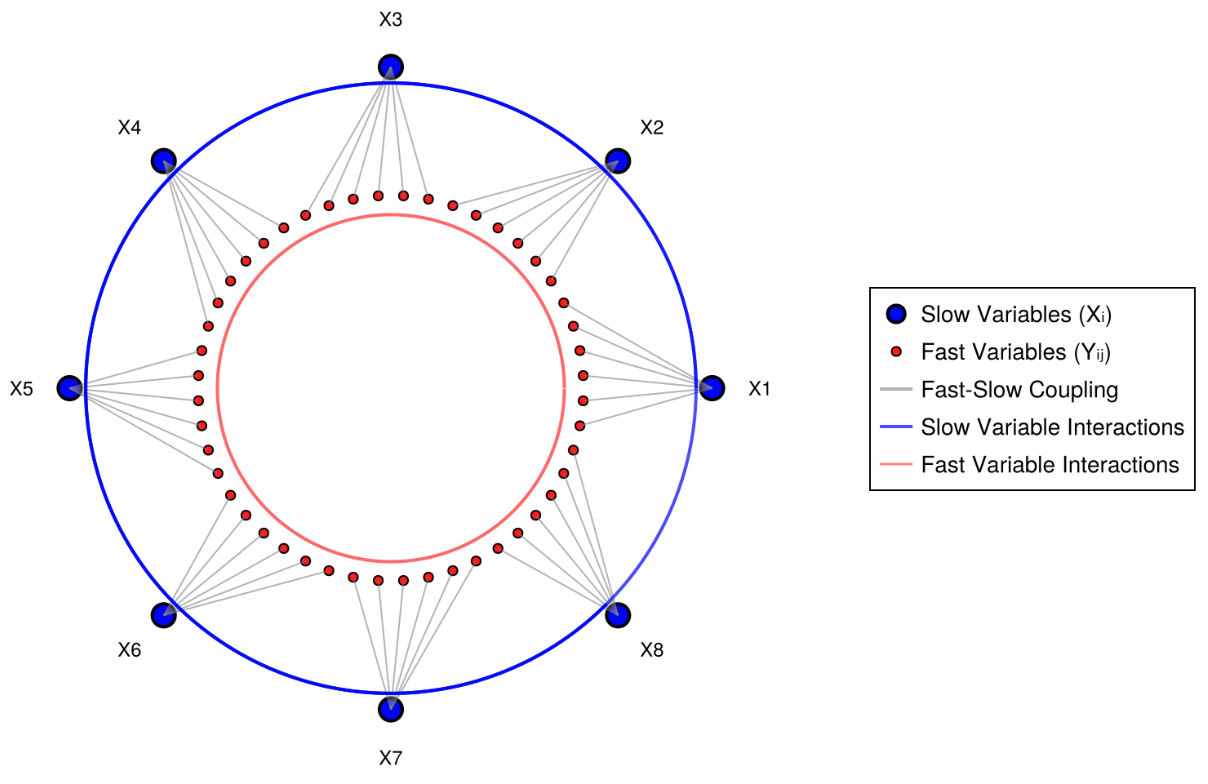

## Subgridscale parametrizations in the Lorenz96 model

We can now start to formulate a subgridscale parametrization in the Lorenz96 model: 

$$
\begin{align}
\frac{dX_i}{dt} &= (X_{i+1} - X_{i-2}) X_{i-1} - X_i + F - P(X) \\
\end{align}
$$

in this case, we want to parametrize the effect $P$ of the fast variables $Y$ on $X_i$ purely based on the inputs of $X_i$ that we have avaliable as 

$$
\begin{align}
P(X) \approx \frac{hc}{b} \sum_{j=1}^J Y_{i,j}
\end{align}
$$

In it's simplest form we just try to learn this as a scalar function $P: \mathbb{R} \rightarrow \mathbb{R}$: $P(X_i) \approx \frac{hc}{b} \sum_{j=1}^J Y_{i,j}$, but you could also test in the workshop if modelling it as $P:\mathbb{R}^K \rightarrow \mathbb{R}^K$ has advantages. 

## Training and Testing Setup 

* To learn this parametrization you can run the two-layer Lorenz system in the repository and collect training data
* The parametrization is then tested and evaluated on a two-layer simulation in which the second-layer is regarded as non-observed:
   * How accuarate is your subgrid scale parametrization in replicating the full system?

## Online vs Offline Training and Parametrization 

As in full Earth system models we have different ways we could train this parametrization: 
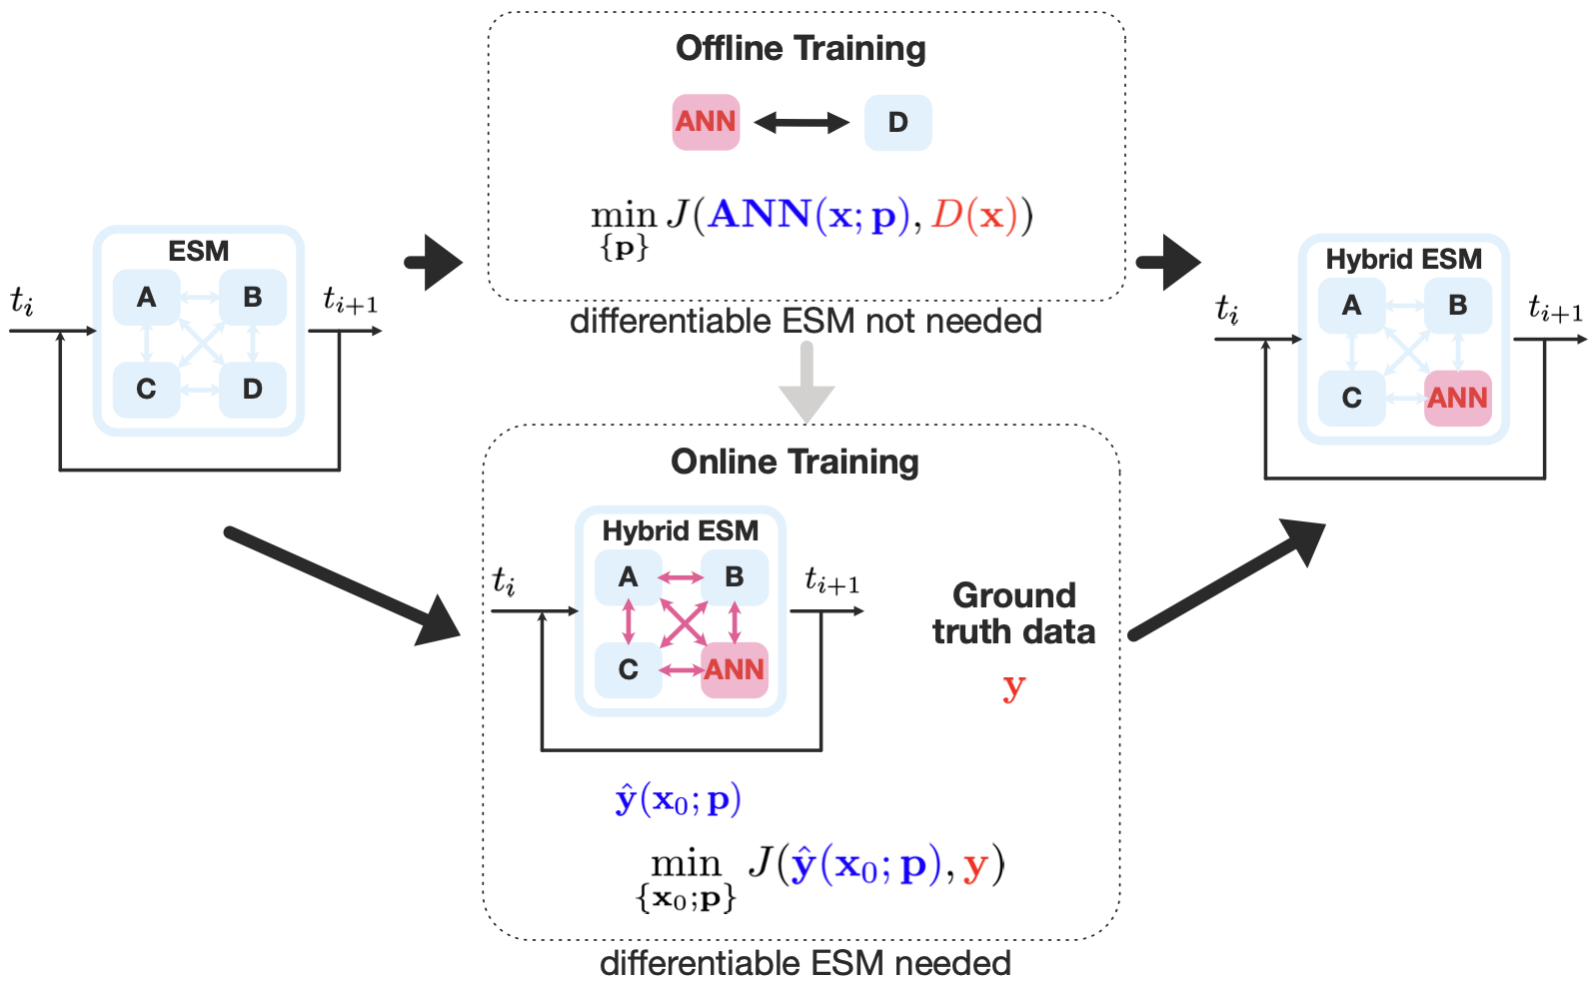

* In an offline training setup: You seperately learn the parametrization $P(X) \approx \frac{hc}{b} \sum_{j=1}^J Y_{i,j}$ and then plug it back in your model
* In an online training model: You train the parametrization directly within the full hybrid model. In real ESMs this is can be advantagous for stability, and might increase accuracy when the scales are actually not clearly seperated, see e.g. [Gelbrecht, 2023](https://gmd.copernicus.org/articles/16/3123/2023/) or [Kochkov, 2021](https://pnas.org/doi/full/10.1073/pnas.2101784118).

The Lorenz96 system is already trivially differentiable, in contrast to almost all proper ESMs, is therefore a nice test case for these method. 

## Different ML Architectures 

* Test different architectures to fit the subgridscale parametrizations: MLP, CNNs, Polynomials, ...
* Can you think of other methods and algorithms that might fit? 

## And now, some Code: 

Let's integrate the Lorenz96 and plot it. We already have everything pre-defined here in the repository (also in a version that's GPU compatible) and we use the ODE solvers from SciML / `OrdinaryDiffEq` to solve it: 

In [1]:
import Pkg
Pkg.activate("..") 
using EllisSummerSchool, CairoMakie, OrdinaryDiffEq, DiffEqCallbacks, CairoMakie

  Activating project at `~/Nextcloud/EllisSummerSchool`
Precompiling packages...
   1092.0 ms  ? DiffEqBase
   1256.0 ms  ? DiffEqBase → DiffEqBaseSparseArraysExt
   1445.6 ms  ? DiffEqBase → DiffEqBaseChainRulesCoreExt
   2389.0 ms  ? DiffEqBase → DiffEqBaseDistributionsExt
   1887.1 ms  ? OrdinaryDiffEqCore
   4249.2 ms  ? DiffEqCallbacks
   1854.5 ms  ? OrdinaryDiffEqCore → OrdinaryDiffEqCoreEnzymeCoreExt
   6255.6 ms  ? DiffEqBase → DiffEqBaseForwardDiffExt
   1928.5 ms  ? OrdinaryDiffEqHighOrderRK
   5676.1 ms  ? NonlinearSolveBase → NonlinearSolveBaseDiffEqBaseExt
   2716.2 ms  ? OrdinaryDiffEqStabilizedRK
   5146.6 ms  ? OrdinaryDiffEqExplicitRK
   4570.7 ms  ? OrdinaryDiffEqSymplecticRK
  12721.3 ms  ? DiffEqBase → DiffEqBaseUnitfulExt
   5496.3 ms  ? OrdinaryDiffEqSSPRK
   4624.8 ms  ? OrdinaryDiffEqFunctionMap
   4601.8 ms  ? OrdinaryDiffEqLinear
   8674.9 ms  ? OrdinaryDiffEqLowOrderRK
   5437.7 ms  ? OrdinaryDiffEqVerner
   4219.6 ms  ? OrdinaryDiffEqRKN
   2868.8 ms  ? Ord

In [2]:
model = TwoLayerLorenz96(K=36, J=10)
p = default_parameters()
u0 = default_initial_condition(model)
dt = 0.005
tspan = (0., 5.)
prob = ODEProblem(model, u0, tspan, p)
sol = solve(prob, Tsit5(), saveat=dt)
sol_data = Array(sol);

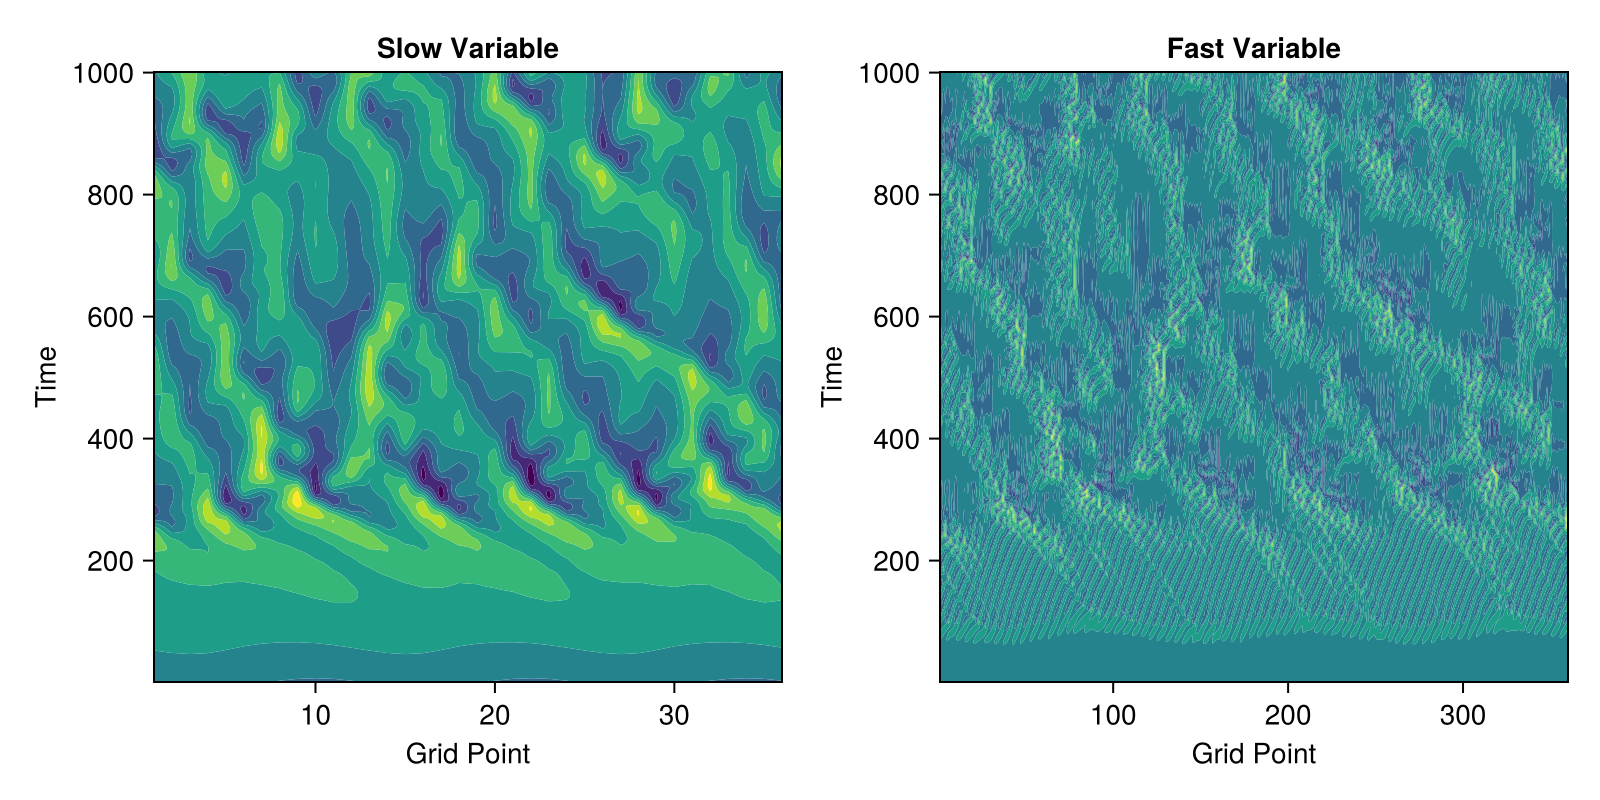

In [3]:
fig = Figure(size=(800, 400))
ax_X = Axis(fig[1,1], title="Slow Variable", xlabel="Grid Point", ylabel="Time")
contourf!(ax_X, sol_data[1:model.K, :]) # heatmap also works 

ax_Y = Axis(fig[1,2], title="Fast Variable", xlabel="Grid Point", ylabel="Time")
contourf!(ax_Y, sol_data[(model.K+1):end, :])
fig

Or as a polar plot: 

In [4]:
animate_polar_plot(model, sol, rlimits=(-12,12));

<video width=400 height=400
       src="lorenz96_animation.mp4"
       controls>
</video>

We can also directly record the subgrid term $\frac{hc}{b} \sum_{j=1}^J Y_{i,j}$ while solving the model with a `SavingCallback`, I already predefined you a helper function `subgrid_save_func` for that: 

In [4]:
#callback type info  = typeof(time), typeof(saved data) 
subgrid_data = SavedValues(typeof(tspan[1]), typeof(u0)) 

cb = SavingCallback(subgrid_save_func, subgrid_data, saveat=dt);

In [9]:
sol = solve(prob, Tsit5(), saveat=dt, callback=cb);

You can get the saved subgrid terms then as:

In [8]:
subgrid_data.saveval

1001-element Vector{Vector{Float64}}:
 [0.008119179347418438, 0.03121845684475708, 0.02413091049584991, -0.015069566266029859, 0.038432816559092246, -0.019402862259466563, 0.05819458179596865, 0.039004028756440046, 0.06797752563951047, 0.01779814963641526  …  -0.03468581951125474, 0.022682728146236848, -0.001501659293376473, -0.009244054323036412, -0.003591879099008882, -0.026190266175210662, -0.000847585224190186, 0.013457410396373722, 0.06487282270281404, -0.05022751809150924]
 [0.009043272025739745, 0.04300500493792421, 0.04554726866779154, 0.011794135788539677, 0.05927588437612297, -0.005111724169139692, 0.05694253515897685, 0.026602950240368163, 0.04511536237255998, -0.00551087426611978  …  -0.010540518007022517, 0.04727463567230161, 0.02090665983664098, 0.004633858016319319, -0.001844721806862141, -0.03552503129938641, -0.020321342760011588, -0.009973536373007628, 0.04209897356101788, -0.057851429234896994]
 [0.012828169183754137, 0.05705702971157765, 0.06877321150556256, 0.04014

## Now, for ML

Do you already have some experience with ML in Julia? If so, great, just go ahead and start working. In the other notebook there are also some details about Neural ODEs that might still be helpful. 

For everyone who needs an introduction to ML in Julia, I collected some recourses in the other notebook. 